# 0. Import Libraries

In [57]:
import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


%matplotlib inline

# 1. Business Understanding

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

This kaggle competition asks us to predict the price of a house, using a data set from Ames, Iowa containing 79 explainatory variables. 

This project will explore the data to understand which features can be used in a predictive model, prepare the data, try several different data modelling methods to predict the price and evaluate how well the model has performed.

The data provided for the competition consists of train and test datasets, however as the test data is used for submitting to the comptetition it does not contain and price information, it is not possible to evaluate model performance on it. As a result I will be focusing on the train dataset provided for the purposes of this exercise, and ignoring the test dataset.

The data will be cleaned, prepared for model evaluation and three regression models will be tried to most accurately predict sale price. I will try a simple linear regression, sklearn's random forest regressor and finally sklearn's gradient boosted regressor. 

For each model I will look at the accuracy, the Root Mean Square Error(RMSE), which is a good measure of the fit of the model and the adjusted r2 score (adjusted r2 information accessed here: https://www.statology.org/adjusted-r-squared-in-python/) the adjusted r2 score is better than the r2 score when looking at models like random forests as it accounts for overfitting as it adjusts for the number of predictors in the model. 

I expect from previous experience that the gradient boosted regression will yeild the best results.

# 2. Data Understanding

## 2.1 Read in the data

In [2]:
df = pd.read_csv('data/train.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2.2 Explore the data

In [ ]:
pd.set_option('display.max_columns', None)
df.describe(include = 'all')

Lets go through these with the supporting data description text file and make observations:
- MSSubClass: this is being read as numeric but should be categorical
- Standard unit of length seems to be feet, ensure this is consistent throughout dataset and outputs
- Some of these categorical fields have a natural order or rating to these 

## 2.3 Sense check the data

Obviously there are many features which will be important in dictating the price of a house, however common sense dictates two of the most obvious ones will be location and size. Lets explore these quickly to see if this makes sense

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

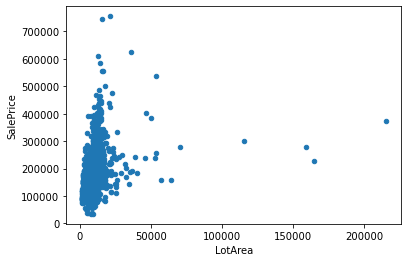

In [4]:
df.plot.scatter(x ='LotArea', y = 'SalePrice')

Seeing several huge properties. Lets look at these a bit further

In [5]:
df[df['LotArea']>50000].sort_values(by = 'LotArea',ascending = False)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,Sev,Timber,Norm,Norm,2fmCon,1.5Fin,5,6,1965,1965,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,ALQ,1249,BLQ,147,103,1499,GasA,Ex,Y,SBrkr,1619,167,0,1786,2,0,2,0,3,1,TA,7,Typ,2,Gd,Attchd,1965.0,Fin,2,529,TA,TA,Y,670,0,0,0,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950
249,250,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697,Unf,0,747,1444,GasA,Gd,Y,SBrkr,1444,700,0,2144,0,1,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2,389,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal,277000
706,707,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219,Unf,0,424,1643,GasA,TA,Y,SBrkr,1824,0,0,1824,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2,739,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal,302000
451,452,20,RL,62.0,70761,Pave,NaN,IR1,Low,AllPub,Inside,Mod,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,655,Unf,0,878,1533,GasA,TA,Y,SBrkr,1533,0,0,1533,1,0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1975.0,Unf,2,576,TA,TA,Y,200,54,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,Normal,280000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
1396,1397,20,RL,NaN,57200,Pave,NaN,IR1,Bnk,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,5,5,1948,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,353,Rec,334,60,747,GasA,TA,Y,SBrkr,1687,0,0,1687,1,0,1,0,3,1,TA,7,Min1,2,TA,Detchd,1966.0,Unf,2,572,TA,TA,N,0,0,50,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,160000
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
457,458,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,CulDSac,Mod,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,Gd,BLQ,1116,Unf,0,248,1364,GasA,Ex,Y,SBrkr,1663,0,0,1663,1,0,1,0,2,1,Gd,6,Min1,2,Gd,Attchd,1954.0,Fin,2,529,TA,TA,Y,224,137,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,256000
384,385,60,RL,NaN,53107,Pave,NaN,IR2,Low,AllPub,Corner,Mod,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None

Nothing really stand out here, other than they are mostly detached single family properties which makes sense. Lets redo the plot without these

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

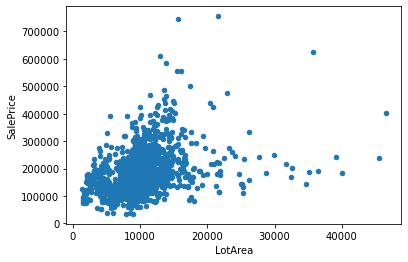

In [6]:
df[df['LotArea']<50000].plot.scatter(x ='LotArea', y = 'SalePrice')

Can see a link here between larger lot sizes and higher prices. 

Now lets look at neighbourhoods

<AxesSubplot:title={'center':'SalePrice'}, xlabel='Neighborhood'>

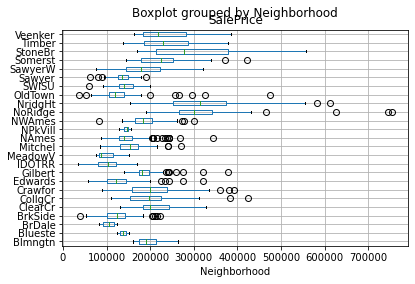

In [7]:
df.boxplot(by ='Neighborhood', column ='SalePrice',vert=False)

Seems like there's a range of costs within each NH but can straight away see some price variation between them

# 3. Data Preparation
## 3.1 Tidying up field types 

Tidy up fields we noticed earlier, firstly create functions to factorise some fields which are ordered

In [8]:
'''
All function definitions:
When there are fields with a rating, for example from poor to excellent 
give these a numerical rating instead
input: column dame from df in string format
output: mapped column in df in numeric format
'''
def rating1(colname):
    df[colname] = df[colname].map({'NA': 0,
                                   'Po': 1,
                                   'Fa': 2,
                                   'TA': 3,
                                   'Gd': 4,
                                   'Ex': 5})

def rating2(colname):
    df[colname] = df[colname].map({'NA': 0,
                                   'No': 1,
                                   'Mn': 2,
                                   'Av': 3,
                                   'Gd': 4})
    
def rating3(colname):
    df[colname] = df[colname].map({'NA' : 0,
                                   'Unf': 1,
                                   'LwQ': 2,
                                   'Rec': 3,
                                   'BLQ': 4,
                                   'ALQ': 5,
                                   'GLQ': 6})
    
def rating4(colname):
    df[colname] = df[colname].map({'N': 0,'P':0.5,'Y': 1})
    
def rating5(colname):
    df[colname] = df[colname].map({'Sal' : 0,                                
                                   'Sev' : 1,
                                   'Maj2': 2,
                                   'Maj1': 3,
                                   'Mod' : 4,
                                   'Min2': 5,
                                   'Min1': 6,
                                   'Typ' : 7})
def rating6(colname):
    df[colname] = df[colname].map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
    
def rating7(colname):
    df[colname] = df[colname].map({'NA':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4})

run functions

In [9]:
rating1('ExterQual')
rating1('ExterCond')
rating1('BsmtQual')
rating1('BsmtCond')
rating1('HeatingQC')
rating1('KitchenQual')
rating1('FireplaceQu')
rating1('GarageQual')
rating1('GarageCond') 
rating1('PoolQC')

rating2('BsmtExposure')

rating3('BsmtFinType1')
rating3('BsmtFinType2')
        
rating4('CentralAir')
rating4('PavedDrive')

rating5('Functional')

rating6('GarageFinish')

rating7('Fence')

df['MSSubClass'] = df['MSSubClass'].astype(str)

pd.set_option('display.max_columns', None)
df.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460.00000,1460.000000,1460,1423.000000,1423.000000,1422.000000,1423.000000,1460.000000,1422.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460.000000,1459,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,770.000000,1379,1379.000000,1379.000000,1460.000000,1460.000000,1379.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,7.000000,281.000000,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,15,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,9,6,NaN
top,NaN,20,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,NaN,NaN,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,NaN,NaN,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Attchd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,536,1151,NaN,NaN,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,NaN,NaN,647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1428,NaN,NaN,1334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,NaN,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,3.39589,3.083562,NaN,3.579761,3.011244,1.673699,3.638089,443.639726,1.280591,46.549315,567.240411,1057.429452,NaN,4.145205,0.934932,NaN,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,3.511644,6.517808,6.841781,0.613014,3.461039,NaN,1978.506164,1.816534,1.767123,472.980137,2.975344,2.973894,0.928082,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,3.714286,2.939502,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,NaN,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,0.57428,0.351054,NaN,0.680602,0.287846,1.047297,2.054910,456.098091,0.880249,161.319273,441.866955,438.705324,NaN,0.959501,0.246731,NaN,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.663760,1.625393,0.667698,0.644666,0.743705,NaN,24.689725,0.812896,0.747315,213.804841,0.248598,0.239527,0.248296,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,1.253566,0.746352,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,NaN,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 3.2 Deal with Nulls
Firstly lets identify columns containing nulls and see what we can do about them

In [10]:
percent_missing = df.isnull().sum() * 100 / len(df)
print(percent_missing.sort_values(ascending = False).head(20))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Id               0.000000
dtype: float64


The top 5 categories above have nulls, likely indicating a lack of a feature. For example its not suprising that 99.5% of homes don't have a pool and 96% don't have any misc features. 
For these fill nas with zeros.

In [11]:
def lacking_feature (colname):
    df[colname] = df[colname].fillna(0)
    
lacking_feature('PoolQC')
lacking_feature('MiscFeature')     
lacking_feature('Alley')           
lacking_feature('Fence')           
lacking_feature('FireplaceQu')

Lets have a look at lot frontage compared to lot config

In [12]:
df.LotFrontage.isnull().groupby([df['LotConfig']]).sum() * 100 / len(df)

LotConfig
Corner     4.246575
CulDSac    3.356164
FR2        0.958904
FR3        0.000000
Inside     9.178082
Name: LotFrontage, dtype: float64

No very obvious links here, so lets use the mean of each type to impute the nulls here

In [13]:
#df.loc[marketing_train.loc[:,i].isnull(),i]=marketing_train.loc[:,i].mean()
df['LotFrontage'] = df['LotFrontage'].fillna(df.groupby('LotConfig')['LotFrontage'].transform('mean'))

Next we have garage features, can probably assume that there is no garage for these properties as the null proportion is spread out equally. 
- GarageYrBlt: lets make this the same as the year the house was built
- GarageCond: fill with a 0
- GarageFinish: fill with a 0
- GarageQual: fill with a 0
- GarageType: fill with a 'NA'

In [14]:
df['GarageYrBlt']=df['GarageYrBlt'].fillna(df['YearBuilt'])
lacking_feature('GarageCond')
lacking_feature('GarageFinish')
lacking_feature('GarageQual')
df['GarageType'] = df['GarageType'].fillna('NA')

Lets do a similar thing with basements, fill all of these with 0s which indicates no basement

In [15]:
df['BsmtExposure']= df['BsmtExposure'].fillna(0)
df['BsmtFinType2']= df['BsmtFinType2'].fillna(0)
df['BsmtFinType1']= df['BsmtFinType1'].fillna(0)
df['BsmtQual']    = df['BsmtQual']    .fillna(0)
df['BsmtCond']    = df['BsmtCond']    .fillna(0)

Last few, lets impute these as well 
- MasVnrType: impute with the none field which seems safest
- MasVnrArea: impute with 0s
- Electrical: impute with 'Mix'

In [16]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
lacking_feature('MasVnrArea')
df['Electrical'] = df['Electrical'].fillna('Mix')

## 3.3 Correlation matrix

Lets have a look at the correlation between the numeric features

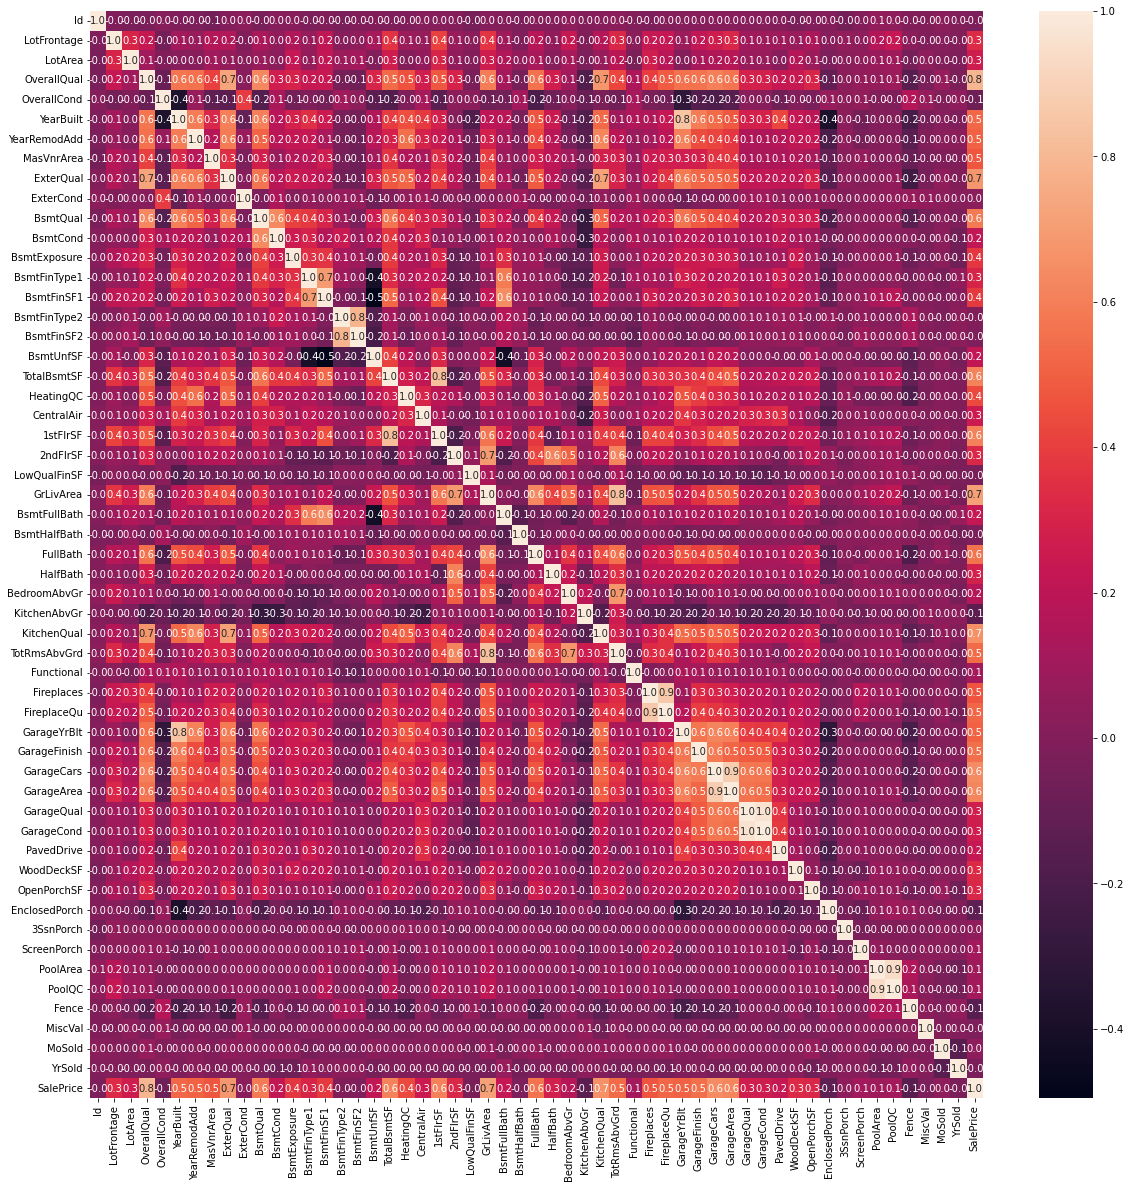

In [17]:
fig, ax = plt.subplots(figsize=(20,20))    
sn.heatmap(df.corr(), annot=True, fmt=".1f");

We are seeing a few correlations, probably where we would expect them, e.g. with garage area and cars. May as well keep these all in for now

Also seeing some good correlations with sale price early on, can check this later after the modelling process

## 3.4 Categorical Data
Lets deal with categorical data by creating dummy variables

In [21]:
cat_df = df.select_dtypes(include=['object']) 

print("number of categorical variables:", cat_df.shape[1])

def create_dummy_df(df,cat_cols):
    '''
    returns categorical data in wide rather than narrow format
    instead of categorical data being contained within a column with multiple values it is split out into multiple columns containing binary flags
    input:    categorical columns in narrow format
    output:   dummy/binary columns of categorical variables
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)
        except:
            continue
    return df

df = create_dummy_df(df,cat_df.columns)

#print(df_new.head())
print(df.shape)

number of categorical variables: 0
(1460, 220)


We still have plenty fewer columns than rows so model will be fine to run

# 4. Data Modelling

Start by separating our our columns into id, explainatory and response

In [23]:
i = df['Id']
x = df.drop(['SalePrice','Id'], axis=1) #df.loc[:, df.columns != []]
y = df['SalePrice']

Now split into test and train data sets

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =.3, random_state = 42)

## 4.1 Linear Regression
Lets start off by buiding a simple linear regression model

In [26]:
#instantiate model
lm_model = LinearRegression()

#fit the training ds
lm_model.fit(x_train, y_train)

#predict test data
y_test_preds_lm = lm_model.predict(x_test)

## 4.2 Random forest
Next lets build a random forest model

In [112]:
#instantiate model
rf_model = RandomForestRegressor(random_state = 42)

#fill out some paramaters
param_grid = {'n_estimators': [50, 100,1000],'max_depth' : [5,6,7,8]}

#cross validation
CV_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv= 5)

#fit training
CV_rf.fit(x_train, y_train)
#look at the best parameters
CV_rf.best_params_

{'max_depth': 8, 'n_estimators': 1000}

Input this back into the model and make our predictions

In [113]:
rf_model=RandomForestRegressor(random_state=42, n_estimators= 1000, max_depth=8).fit(x_train, y_train)
#predict test data
y_test_preds_rf = rf_model.predict(x_test)

## 4.3 Gradient Boosted Trees
Finally lets try some gradient boosted trees

In [94]:
gb_model = GradientBoostingRegressor()

#fill out some paramaters
param_grid = {'n_estimators': [50, 100, 500],'max_depth' : [5,6,7,8]}

#cross validation
CV_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv= 5)

#fit training
CV_gb.fit(x_train, y_train)
#look at the best parameters
CV_gb.best_params_

{'max_depth': 6, 'n_estimators': 100}

Input this back into our model

In [99]:
gb_model=GradientBoostingRegressor(n_estimators= 100, max_depth=6).fit(x_train, y_train)
#predict test data
y_test_preds_gb = gb_model.predict(x_test)

# 5. Evaluation

Now we have our models let's begin by plotting our results against the actual sales values to see if they look as expected 

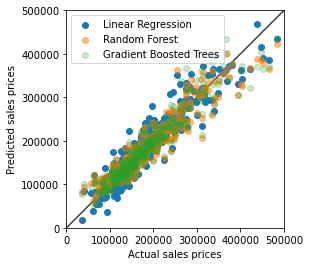

In [114]:
fig, ax = plt.subplots()

ax.scatter(y_test,y_test_preds_lm, alpha = 1,label = 'Linear Regression')
ax.scatter(y_test,y_test_preds_rf, alpha = 0.5,label = 'Random Forest')
ax.scatter(y_test,y_test_preds_gb, alpha = 0.25,label = 'Gradient Boosted Trees')
plt.xlabel("Actual sales prices")
plt.ylabel("Predicted sales prices")
plt.xlim(0,500000)
plt.ylim(0,500000)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.legend()
plt.show()

This doesn't really tell us much but its useful to see that there's no obvious skew in any of the models.
It looks as though the decision tree models are hugging the x=y line closer than the linear regression data points, but lets have a look at some metrics to give us further info rather than just seeing by eye. 

Firstly lets create a function which gives us our metrics, that we can reuse for each model

In [110]:
def metrics(y_preds):
    '''
    Function for each model to output model metrics
    imput the predicted scores from the model
    outputs the accuracy, rmse, r2 and adjusted r2 score
    '''
    n = len(y_test)   #number of rows in the data
    y_preds =y_preds  #model predicted ys
    k = x.shape[1]    #number of parameters
    
    #accuracy
    acc = 100 - np.mean(100 * (abs(y_preds - y_test) / y_test))
    
    #root mean squared error
    rmse = math.sqrt(mean_squared_error(y_test,y_preds))
    
    #r2 score, use to calculate the adjusted score in the next step
    r2 = r2_score(y_test, y_preds)
    
    #adjusted r2 score
    r2a = 1 - ((1-r2)*(n-1)/(n-k-1))
    
    #print this all out
    print("accuracy: {}% , rmse $: {}, r2: {}, adjusted r2: {}".format(round(acc,2), 
                                                                  round(rmse,2), 
                                                                  round(r2,2), 
                                                                  round(r2a,2)
                                                                 ))
    return acc, rmse, r2, r2a

In [115]:
print('-----------Linear Regression-----------')
lm_acc, lm_rmse, lm_r2, lm_r2a = metrics(y_test_preds_lm)
print('-----------Random Forest-----------')
rf_acc, rf_rmse, rf_r2, rf_r2a = metrics(y_test_preds_rf)
print('-----------Grad Boosted Trees-----------')
gb_acc, gb_rmse, gb_r2, gb_r2a = metrics(y_test_preds_gb)

-----------Linear Regression-----------
accuracy: 87.51% , rmse $: 44034.5, r2: 0.72, adjusted r2: 0.45
-----------Random Forest-----------
accuracy: 89.74% , rmse $: 27483.61, r2: 0.89, adjusted r2: 0.78
-----------Grad Boosted Trees-----------
accuracy: 90.31% , rmse $: 25967.29, r2: 0.9, adjusted r2: 0.81


# Conclusion

Great, we can see that of all the models the gradient boosted trees perform the best, they give the highest accuracy, lowest RMSE and best r2 scores. 

This is as expected, as gradient boosted trees are generally more accurate as each tree will learn from errors in previous trees, in comparison the trees in a random forest are all created independetly of each other. Gradient boosted trees are also less likely to overfit than random forests, meaning that this method might be more sustainable moving forwards.

Logistic regression is a very simple model so we wouldn't necessarily expect it to perform fantastically, particularly compared to decision tree models. 